# Introduction

- TODO: Write introduction
- TODO: Flesh out sections with text

# Methods

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries, Hopkins2007QuasarFormationDensity,
                                  ModifiedSchechter, Marconi2004BHMF, Hopkins2007QuasarNumberDensity,
                                  Goulding2019J1010Binaries)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter)

<ipython-input-1-857a52c9f494>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 12)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(4096, 32)

In [3]:
# class declarations
class split_normal(rv_continuous):
    def __init__(self, loc, scale1, scale2, *args, **kwargs):
        self.loc = loc
        self.scale1 = scale1
        self.scale2 = scale2
        self.normalization = 2 / (scale1 + scale2)
        super().__init__(self, *args, **kwargs)
        
    def _pdf(self, x):
        if x < self.loc:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale2)
    
    def _cdf(self, x):
        if x < self.loc:
            return self.normalization * self.scale1 * truncnorm.cdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return 1 - self.normalization * self.scale2 * (1 - truncnorm.cdf(x, self.a, self.b, self.loc, self.scale2))
    
    def _ppf(self, q):
        p = self.scale1 / (self.scale1 + self.scale2)
        
        output = np.where(q <= p,
                          self.loc + self.scale1
                          * truncnorm.ppf(.5 * (self.scale1 + self.scale2) * q
                                          / self.scale1, self.a, self.b),
                          self.loc + self.scale2
                          * truncnorm.ppf(0.5 * ((self.scale1 + self.scale2)
                                                 * (1 + q) - 2 * self.scale1)
                                          / self.scale2, self.a, self.b))
        return np.squeeze(output)

In [4]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

## Dependencies/Assumptions

### Shared

#### Parameter space

In [5]:
log_m_bh_min = 7
log_m_bh_max = 10

log_m_bh_range = np.linspace(log_m_bh_min, log_m_bh_max, num=n_mesh)

z_min = 0
z_max = 3
z_range = np.linspace(z_min, z_max, num=n_mesh)

q_min = 0.25
q_max = 1
q_range = np.linspace(q_min, q_max, num=n_mesh)

#### Fiducial values

In [6]:
fidhz = (1 / u.yr).to(u.Hz)

#### Cappellari (2013)

##### $M_{\rm{gal}} - M_{K}$ model parameters

In [7]:
a_cappellari = unc.normal(10.5829, std=0.0086, n_samples=n_samples).distribution
b_cappellari = unc.normal(-0.4449, std=0.0091, n_samples=n_samples).distribution

##### $M_{\rm{gal}} - K$ model

In [8]:
c_intercept = a_cappellari + (b_cappellari * 23)
c_slope = b_cappellari
cappellari_mgal_k = Linear1D(slope=c_slope,
                             intercept=c_intercept,
                             n_models=n_samples)

In [9]:
print(cappellari_mgal_k)
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'wb') as f:
    pickle.dump(cappellari_mgal_k, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
           slope              intercept     
    -------------------- -------------------
     -0.4375860798083167   0.514917281175368
    -0.43227126272634686  0.6353471411956289
    -0.45089006535743315 0.22586597230690408
     -0.4321771174148955  0.6471817808378777
    -0.44235974865987915 0.40018809165409763
     -0.4424480217599389  0.3951923085558615
    -0.44061763563874606  0.4508868200759295
     -0.4388810107923193  0.4947393616791391
     -0.4343478613634414  0.6001661523086508
    -0.43746677502997755  0.5244257368488707
                     ...                 ...
    -0.44821911085799215  0.2666197473402363
     -0.4376514475853868  0.5199949255384748
    -0.43232513732671507   0.647166244812972
     -0.4552599785529059  0.1163507738691294
    -0.44021115583526466  0.4524282091467011
    -0.44942368932674237 0.25040141237093394
    -0.45627252369134247 0.07860312708283423
     -0.450406761954

#### McConnell & Ma (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [10]:
alpha_mcconnell_ma = unc.normal(8.46, std=.08, n_samples=n_samples).distribution
beta_mcconnell_ma = unc.normal(1.05, std=.11, n_samples=n_samples).distribution
intrinsic_disp_mcconnell_ma = np.random.normal(scale=.34, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [11]:
mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
mm_slope = beta_mcconnell_ma
mcconnell_ma_m_mbulge = Linear1D(slope=mm_slope,
                                 intercept=mm_intercept,
                                 n_models=n_samples)

In [12]:
print(mcconnell_ma_m_mbulge)
with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(mcconnell_ma_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
          slope             intercept     
    ------------------ -------------------
    0.9948678111149856 -2.4948429944692467
    1.2345437999432058  -5.028753515265704
     0.907218089364985  -1.494064527164646
    1.0244407875434736 -2.7410142975701266
    1.1887350090776425  -4.559390284501006
    0.8932204152319965 -1.3938897722653216
    0.8809527500607638 -1.2053787248781926
    1.1058113878190512  -3.778007234795435
    1.0325249926473743 -2.8291687732524657
    1.0235726162968894 -2.8092534369504634
                   ...                 ...
    0.8779680550562823 -1.1778976340980503
    1.2924637826951801   -5.72801923478622
    1.0944678207950782 -3.5837099264998216
    1.1341251247879063   -4.01173500902058
     1.162818004788557  -4.262077485060209
    1.0761963245727617 -3.3833635210846165
     0.941545962193354 -1.8742924664261356
    1.1491728159132926 -4.1383034284493085
    1.03091231971

### AGN-proxy model

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [13]:
log_m_bh_m_k = cappellari_mgal_k | mcconnell_ma_m_mbulge

#### Mingarelli+ (2017)

##### Mass ratio range

In [14]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [15]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [16]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .34)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### $q$ distribution

In [18]:
var_log_q = np.repeat(.5, n_samples)
mode_log_q = np.repeat(0, n_samples)
median_log_q = mode_log_q + (var_log_q ** 2)

In [19]:
q_distrib = LogNormal1D(mu=median_log_q, std=var_log_q, n_models=n_samples)

In [20]:
print(q_distrib)
with open('../models/q_distrib.pkl', 'wb') as f:
    pickle.dump(q_distrib, f)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
     mu  std
    ---- ---
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
     ... ...
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    Length = 4096 rows


#### Hopkins+ (2007)

##### Differential quasar formation density model parameters

In [21]:
log_formation_rate_normalization = unc.normal(-3.830, std=0.031, n_samples=n_samples).distribution
log_formation_rate_power_law_slope = unc.normal(-4.02, std=0.36, n_samples=n_samples).distribution
log_mass_break_normalization = unc.normal(8.959, std=0.032, n_samples=n_samples).distribution
log_mass_break_k_1 = unc.normal(1.18, std=0.13, n_samples=n_samples).distribution
log_mass_break_k_2 = unc.normal(-6.68, std=0.44, n_samples=n_samples).distribution
low_mass_slope = np.repeat(.2, n_samples)
high_mass_slope_normalization = unc.normal(2.86, std=0.16, n_samples=n_samples).distribution
high_mass_slope_k_1 = unc.normal(1.80, std=0.18, n_samples=n_samples).distribution
high_mass_slope_k_2 = unc.normal(-1.13, std=0.09, n_samples=n_samples).distribution
z_ref = np.repeat(2, n_samples)

##### Differential quasar formation density model

In [22]:
quasar_formation_rate = Hopkins2007QuasarFormationDensity(log_formation_rate_normalization=log_formation_rate_normalization,
                                                          log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                          log_mass_break_normalization=log_mass_break_normalization,
                                                          log_mass_break_k_1=log_mass_break_k_1,
                                                          log_mass_break_k_2=log_mass_break_k_2,
                                                          low_mass_slope=low_mass_slope,
                                                          high_mass_slope_normalization=high_mass_slope_normalization,
                                                          high_mass_slope_k_1=high_mass_slope_k_1,
                                                          high_mass_slope_k_2=high_mass_slope_k_2,
                                                          z_ref=z_ref,
                                                          n_models=n_samples)

In [23]:
print(quasar_formation_rate)
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'wb') as f:
    pickle.dump(quasar_formation_rate, f)

Model: Hopkins2007QuasarFormationDensity
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 4096
Parameters:
    log_formation_rate_normalization log_formation_rate_power_law_slope ... z_ref
    -------------------------------- ---------------------------------- ... -----
                  -3.848714384063697                 -4.370269018620064 ...   2.0
                 -3.8361932586892378                 -4.317073267901405 ...   2.0
                  -3.830213470674555                 -3.576385232221888 ...   2.0
                  -3.802237504243581                -3.6747698702374576 ...   2.0
                 -3.8490396719959206                -3.7984858907492534 ...   2.0
                  -3.824495346359807                -4.0299905473408595 ...   2.0
                 -3.8436374087459897                 -4.584479339080866 ...   2.0
                  -3.829763049465873                -3.4079789345026414 ...   2.0
                  -3.779949114458644                 -3.921248175812073

### Goulding+ (2019) AGN-proxy model

#### Goulding+ (2019) bounds

##### J1010-like quasar parameters

In [24]:
# Number density luminosity bounds
log_l_min = np.log10((.3 * (10 ** 46.) * u.erg / u.s).to(u.Lsun).value)
log_l_max = np.log10((.3 * (10 ** 47.) * u.erg / u.s).to(u.Lsun).value)
log_l_min_goulding = np.repeat(log_l_min, n_samples)
log_l_max_goulding = np.repeat(log_l_max, n_samples)

log_m_min_goulding = 8
log_m_max_goulding = 10

log_m_chirp_min_goulding = log_m_min_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))
log_m_chirp_max_goulding = log_m_max_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))

log_m_bh_min_goulding = log_m_min_goulding - np.log10(1 + q_max)
log_m_bh_max_goulding = log_m_max_goulding - np.log10(1 + q_max)

In [25]:
log_l_min, log_l_max

(11.894149325614856, 12.894149325614856)

#### Sheth+ (2003)

##### Velocity dispersion function parameters

In [26]:
dispersion_normalization_sheth = unc.normal(0.002, std=.0001, n_samples=n_samples).distribution * (WMAP9.h ** 3)
dispersion_break_sheth = np.repeat(88.8, n_samples)  # unc.normal(88.8, std=17.7, n_samples=n_samples).distribution
alpha_sheth = np.repeat(6.5, n_samples)  # unc.normal(6.5, std=1., n_samples=n_samples).distribution
beta_sheth = np.repeat(1.93, n_samples)

##### Velocity dispersion function

In [27]:
sheth_2003_velocity_dispersion_function = ModifiedSchechter(normalization=dispersion_normalization_sheth,
                                                            sigma_break=dispersion_break_sheth,
                                                            alpha=alpha_sheth,
                                                            beta=beta_sheth,
                                                            n_models=n_samples)

In [28]:
print(sheth_2003_velocity_dispersion_function)
with open('../models/Sheth2003_velocity_dispersion_function.pkl', 'wb') as f:
    pickle.dump(sheth_2003_velocity_dispersion_function, f)

Model: ModifiedSchechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
        normalization     sigma_break alpha beta
    --------------------- ----------- ----- ----
     0.000618927557576972        88.8   6.5 1.93
     0.000669448865769063        88.8   6.5 1.93
    0.0006950547696003825        88.8   6.5 1.93
    0.0006527411422308682        88.8   6.5 1.93
    0.0006473430751392051        88.8   6.5 1.93
    0.0006825449469405199        88.8   6.5 1.93
    0.0006148492817788553        88.8   6.5 1.93
    0.0006513516083773293        88.8   6.5 1.93
    0.0006295778206059123        88.8   6.5 1.93
    0.0007123592830598004        88.8   6.5 1.93
                      ...         ...   ...  ...
    0.0006353137089561467        88.8   6.5 1.93
    0.0006774863328139543        88.8   6.5 1.93
    0.0006403574747969214        88.8   6.5 1.93
     0.000601836193781702        88.8   6.5 1.93
     0.000703506028744301        88.8   6.5 1.93
    0.0006566071464792072    

#### Marconi+ (2004)

##### Black hole mass function parameters

In [29]:
b_marconi = unc.normal(4.11, std=.33, n_samples=n_samples).distribution
a_marconi = unc.normal(8.30, std=.07, n_samples=n_samples).distribution - 2.3 * b_marconi
intrinsic_disp_marconi = np.repeat(.3, n_samples)

##### Black hole mass function

In [30]:
marconi_2004_black_hole_mass_function = Marconi2004BHMF(mass_dispersion_intercept=a_marconi,
                                                        mass_dispersion_slope=b_marconi,
                                                        intrinsic_scatter=intrinsic_disp_marconi,
                                                        dispersion_norm=dispersion_normalization_sheth,
                                                        log_dispersion_break=np.log10(dispersion_break_sheth),
                                                        dispersion_alpha=alpha_sheth,
                                                        dispersion_beta=beta_sheth,
                                                        n_models=n_samples)

In [31]:
print(marconi_2004_black_hole_mass_function)
with open('../models/Marconi2004_black_hole_mass_function.pkl', 'wb') as f:
    pickle.dump(marconi_2004_black_hole_mass_function, f)

Model: Marconi2004BHMF
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
    mass_dispersion_intercept mass_dispersion_slope ... dispersion_beta
    ------------------------- --------------------- ... ---------------
          -1.3439547439590047     4.178937744707737 ...            1.93
          -2.0601052888241114     4.398090063412713 ...            1.93
          -1.2844553456591719     4.174356503242851 ...            1.93
          -1.6597618159904677     4.302305675443283 ...            1.93
          -1.7469893491814315     4.373467075567316 ...            1.93
         -0.39175979077148426    3.7677836178354385 ...            1.93
          -1.9263479113442283    4.4223395815135875 ...            1.93
          -0.6297134826208044      3.90513562304638 ...            1.93
          -1.4118107971889433     4.193277990506031 ...            1.93
          -1.3814178228271565     4.147332748243746 ...            1.93
                          ...                   .

#### Hopkins+ (2007)

##### Quasar luminosity function number density parameters

In [32]:
log_norm_hopkins = unc.normal(-4.825, std=0.060, n_samples=n_samples).distribution
log_break_luminosity_norm_hopkins = unc.normal(13.036, std=0.043, n_samples=n_samples).distribution
log_break_luminosity_k1_hopkins = unc.normal(0.632, std=0.077, n_samples=n_samples).distribution
log_break_luminosity_k2_hopkins = unc.normal(-11.76, std=0.38, n_samples=n_samples).distribution
log_break_luminosity_k3_hopkins = unc.normal(-14.25, std=0.80, n_samples=n_samples).distribution
faint_end_slope_norm_hopkins = unc.normal(0.417, std=0.055, n_samples=n_samples).distribution
faint_end_slope_k_hopkins = unc.normal(-0.623, std=0.132, n_samples=n_samples).distribution
bright_end_slope_norm_hopkins = unc.normal(2.174, std=0.055, n_samples=n_samples).distribution
bright_end_slope_k1_hopkins = unc.normal(1.460, std=0.096, n_samples=n_samples).distribution
bright_end_slope_k2_hopkins = unc.normal(-0.793, std=0.057, n_samples=n_samples).distribution
z_ref_hopkins = np.repeat(2, n_samples)

##### Quasar luminosity function number density

In [33]:
hopkins_2007_quasar_number_density = Hopkins2007QuasarNumberDensity(log_l_min=log_l_min_goulding,
                                                                    log_l_max=log_l_max_goulding,
                                                                    log_norm=log_norm_hopkins,
                                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                                    z_ref=z_ref_hopkins,
                                                                    n_models=n_samples)

In [34]:
print(hopkins_2007_quasar_number_density)
with open('../models/Hopkins2007_quasar_number_density.pkl', 'wb') as f:
    pickle.dump(hopkins_2007_quasar_number_density, f)

Model: Hopkins2007QuasarNumberDensity
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
        log_l_min          log_l_max      ... bright_end_slope_k2 z_ref
    ------------------ ------------------ ... ------------------- -----
    11.894149325614856 12.894149325614856 ... -0.8309774604456945   2.0
    11.894149325614856 12.894149325614856 ... -0.8385842719803679   2.0
    11.894149325614856 12.894149325614856 ... -0.8328915447724479   2.0
    11.894149325614856 12.894149325614856 ... -0.7224959257364331   2.0
    11.894149325614856 12.894149325614856 ... -0.7628894996572223   2.0
    11.894149325614856 12.894149325614856 ... -0.7833260063434535   2.0
    11.894149325614856 12.894149325614856 ... -0.7652241556161524   2.0
    11.894149325614856 12.894149325614856 ... -0.8147735840666093   2.0
    11.894149325614856 12.894149325614856 ...  -0.822776607172188   2.0
    11.894149325614856 12.894149325614856 ... -0.7736620130917472   2.0
                   ...            

#### Goulding+ (2019) dual AGN model

##### J1010-like quasar number density

In [35]:
j1010_quasars = Goulding2019J1010Binaries(binary_normalization=np.repeat(1, n_samples),
                                          mass_dispersion_intercept=a_marconi,
                                          mass_dispersion_slope=b_marconi,
                                          intrinsic_scatter=intrinsic_disp_marconi,
                                          dispersion_norm=dispersion_normalization_sheth,
                                          log_dispersion_break=np.log10(dispersion_break_sheth),
                                          dispersion_alpha=alpha_sheth,
                                          dispersion_beta=beta_sheth,
                                          log_l_min=log_l_min_goulding,
                                          log_l_max=log_l_max_goulding,
                                          log_dens_norm=log_norm_hopkins,
                                          log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                          log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                          log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                          log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                          faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                          faint_end_slope_k=faint_end_slope_k_hopkins,
                                          bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                          bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                          bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                          z_ref=z_ref_hopkins,
                                          n_models=n_samples)

### Merger models

#### Bell+ (2003)

##### Galactic mass function parameters

In [36]:
z_bell = 0.
phi_bell = trunc_norm_dist(a=0, b=np.inf, loc=0.0133, scale=0.0006, size=n_samples) * (WMAP9.h ** 3)
log_mgal_break_bell = unc.normal(10.63, std=.01, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
alpha_bell = unc.normal(-0.86, std=.04, n_samples=n_samples).distribution

##### Galactic mass function

In [37]:
bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
                                               log_m_break=log_mgal_break_bell,
                                               exponent=alpha_bell,
                                               n_models=n_samples)

In [38]:
print(bell_2003_galactic_mass_function)
with open('../models/Bell2003_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(bell_2003_galactic_mass_function, f)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
        normalization        log_m_break           exponent     
    --------------------- ------------------ -------------------
     0.004271247323386133 10.950968468896573 -0.9189696485548602
    0.0046209576244580506  10.95976970709159 -0.8725052677878685
     0.004361061277511269   10.9514152129026 -0.8811743610698354
     0.004377489639125991 10.954561785345119 -0.8670577541722064
     0.004077843762556034 10.954684246065174  -0.828784101803213
     0.004550006557884792 10.964021821136702  -0.863695728652833
     0.004288434413969628    10.960714142437 -0.8360943156300628
     0.004206881155482375 10.935589260078661 -0.8719606136942037
     0.004771701205081118 10.958102446108471 -0.8697105525523561
      0.00416395633105592 10.933646923896317 -0.7657743397411362
                      ...                ...                 ...
     0.004443482840708994 10.960370937487928 -0.8389036573095098
     0.

#### Borch+ (2006)

##### Galactic mass function parameters

In [39]:
z_borch = np.array([0, .3, .5, .7, .9])
z_range_borch = np.linspace(0, .9, num=n_mesh)

norm_0_borch = trunc_norm_dist(a=0, b=np.inf, loc=37e-4, scale=4e-4, size=n_samples)
norm_3_borch = trunc_norm_dist(a=0, b=np.inf, loc=17e-4, scale=7e-4, size=n_samples)
norm_5_borch = trunc_norm_dist(a=0, b=np.inf, loc=15e-4, scale=5e-4, size=n_samples)
norm_7_borch = trunc_norm_dist(a=0, b=np.inf, loc=11e-4, scale=4e-4, size=n_samples)
norm_9_borch = trunc_norm_dist(a=0, b=np.inf, loc=9e-4, scale=3e-4, size=n_samples)

log_m_gal_0_borch = unc.normal(10.81, std=.1, n_samples=n_samples).distribution
log_m_gal_3_borch =  unc.normal(10.97, std=.09, n_samples=n_samples).distribution
log_m_gal_5_borch =  unc.normal(10.95, std=.1, n_samples=n_samples).distribution
log_m_gal_7_borch =  unc.normal(11.06, std=.18, n_samples=n_samples).distribution
log_m_gal_9_borch =  unc.normal(11.01, std=.08, n_samples=n_samples).distribution

alpha_0_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_3_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_5_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_7_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_9_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution

##### Galactic mass function

In [40]:
borch_2006_galactic_mass_function = Schechter2D(norm1=norm_0_borch,
                                                norm2=norm_3_borch,
                                                norm3=norm_5_borch,
                                                norm4=norm_7_borch,
                                                norm5=norm_9_borch,
                                                log_m_break1=log_m_gal_0_borch,
                                                log_m_break2=log_m_gal_3_borch,
                                                log_m_break3=log_m_gal_5_borch,
                                                log_m_break4=log_m_gal_7_borch,
                                                log_m_break5=log_m_gal_9_borch,
                                                exp1=alpha_0_borch,
                                                exp2=alpha_3_borch,
                                                exp3=alpha_5_borch,
                                                exp4=alpha_7_borch,
                                                exp5=alpha_9_borch,
                                                n_models=n_samples)

In [41]:
print(borch_2006_galactic_mass_function)
with open('../models/Borch2006_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(borch_2006_galactic_mass_function, f)

Model: Schechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 4096
Parameters:
            norm1                 norm2         ...         exp5       
    --------------------- --------------------- ... -------------------
    0.0034820733396743633 0.0011467291404156526 ... -0.6553545348160851
     0.003472716589742677  0.002694966853028244 ... -0.7561567400929381
     0.003983633511836937   0.00169357494558752 ... -0.7157011651984113
     0.003698355592235045 0.0023764234148628063 ... -0.7440779423373572
    0.0035619493115045305  0.002009391095720827 ... -0.6314950113455768
     0.003802294682618227  0.002697708519309814 ... -0.8711435674439753
    0.0034525772713065736  0.001580809175906866 ... -0.7490005722888328
    0.0028572426622370337 0.0017575666806253201 ...  -0.828041992060726
     0.003141168201861496  0.002220977172077062 ... -0.5565601612593888
     0.004225609557030547  0.002554255679962472 ...  -0.676882198704126
                      ...                   ... .

#### Drory+ (2009)

##### Galactic mass function parameters

In [42]:
z_drory = np.array([0, .3, .5, .7, .9])
z_range_drory = np.linspace(0, .9, num=n_mesh)

norm_0_drory_b = phi_bell
norm_3_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_5_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=1.74, scale=.09, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_7_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.16, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_9_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.94, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)

log_m_gal_0_drory_b = log_mgal_break_bell
log_m_gal_3_drory_b = unc.normal(10.90, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_5_drory_b = unc.normal(10.91, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_7_drory_b = unc.normal(10.95, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_9_drory_b = unc.normal(10.92, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)

alpha_0_drory_b = alpha_bell
alpha_3_drory_b = unc.normal(-1.06, std=.03, n_samples=n_samples).distribution
alpha_5_drory_b = unc.normal(-1.05, std=.02, n_samples=n_samples).distribution
alpha_7_drory_b = unc.normal(-.93, std=.04, n_samples=n_samples).distribution
alpha_9_drory_b = unc.normal(-.91, std=.03, n_samples=n_samples).distribution

norm_0_drory_f = np.zeros(n_samples)
norm_3_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.80, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_5_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_7_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.26, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_9_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.12, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)

log_m_gal_0_drory_f = np.zeros(n_samples) - 2. * np.log10(WMAP9.h)
log_m_gal_3_drory_f = unc.normal(9.63, std=.09, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_5_drory_f = unc.normal(9.70, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_7_drory_f = unc.normal(9.75, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_9_drory_f = unc.normal(9.85, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)

alpha_0_drory_f = np.zeros(n_samples)
alpha_3_drory_f = unc.normal(-1.73, std=.09, n_samples=n_samples).distribution
alpha_5_drory_f = unc.normal(-1.76, std=.16, n_samples=n_samples).distribution
alpha_7_drory_f = unc.normal(-1.65, std=.08, n_samples=n_samples).distribution
alpha_9_drory_f = unc.normal(-1.65, std=.24, n_samples=n_samples).distribution

##### Galactic mass function

In [43]:
drory_2009_galactic_mass_function = DoubleSchechter2D(norm11=norm_0_drory_b,
                                                      norm12=norm_3_drory_b,
                                                      norm13=norm_5_drory_b,
                                                      norm14=norm_7_drory_b,
                                                      norm15=norm_9_drory_b,
                                                      norm21=norm_0_drory_f,
                                                      norm22=norm_3_drory_f,
                                                      norm23=norm_5_drory_f,
                                                      norm24=norm_7_drory_f,
                                                      norm25=norm_9_drory_f,
                                                      log_m_break11=log_m_gal_0_drory_b,
                                                      log_m_break12=log_m_gal_3_drory_b,
                                                      log_m_break13=log_m_gal_5_drory_b,
                                                      log_m_break14=log_m_gal_7_drory_b,
                                                      log_m_break15=log_m_gal_9_drory_b,
                                                      log_m_break21=log_m_gal_0_drory_f,
                                                      log_m_break22=log_m_gal_3_drory_f,
                                                      log_m_break23=log_m_gal_5_drory_f,
                                                      log_m_break24=log_m_gal_7_drory_f,
                                                      log_m_break25=log_m_gal_9_drory_f,
                                                      exp11=alpha_0_drory_b,
                                                      exp12=alpha_3_drory_b,
                                                      exp13=alpha_5_drory_b,
                                                      exp14=alpha_7_drory_b,
                                                      exp15=alpha_9_drory_b,
                                                      exp21=alpha_0_drory_f,
                                                      exp22=alpha_3_drory_f,
                                                      exp23=alpha_5_drory_f,
                                                      exp24=alpha_7_drory_f,
                                                      exp25=alpha_9_drory_f,
                                                      n_models=n_samples)

In [44]:
print(drory_2009_galactic_mass_function)
with open('../models/Drory2009_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(drory_2009_galactic_mass_function, f)

Model: DoubleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 4096
Parameters:
            norm11                norm12        ...        exp25       
    --------------------- --------------------- ... -------------------
     0.004271247323386133 0.0009809128697744604 ... -1.5667171421117376
    0.0046209576244580506 0.0010175124149329104 ...  -1.236450501828006
     0.004361061277511269 0.0009772191925992962 ...  -1.938992136403773
     0.004377489639125991 0.0010063858791763455 ...  -1.765992912616264
     0.004077843762556034 0.0009341516326543616 ... -2.0560989361429507
     0.004550006557884792 0.0007729697724138113 ...  -1.932157220832517
     0.004288434413969628   0.00096911328643268 ... -1.7757251829726934
     0.004206881155482375 0.0010099131243240468 ...  -1.715344393437535
     0.004771701205081118 0.0009083008223295909 ...  -1.934595450985523
      0.00416395633105592 0.0009465649835035409 ...  -2.020757730390171
                      ...                  

#### Ilbert+ (2010)

##### Galactic mass function parameters

In [45]:
z_ilbert = np.array([0, .3, .5, .7, .9, 1.1, 1.35, 1.75])
z_range_ilbert = np.linspace(0, 1.75, num=n_mesh)

norm_0_ilbert_q = phi_bell
norm_3_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.12, scale=.07, size=n_samples) * 1e-3
norm_5_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.87, scale=.04, size=n_samples) * 1e-3
norm_7_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.15, scale=.03, size=n_samples) * 1e-3
norm_9_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.03, size=n_samples) * 1e-3
norm_11_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.55, scale=.02, size=n_samples) * 1e-3
norm_135_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.26, scale=.02, size=n_samples) * 1e-3
norm_175_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.1, scale=.04, size=n_samples) * 1e-3

log_m_gal_0_ilbert_q = log_mgal_break_bell
log_m_gal_3_ilbert_q = unc.normal(11.13, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_q = unc.normal(10.97, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_q = unc.normal(10.83, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_q = unc.normal(10.77, std=.01, n_samples=n_samples).distribution
log_m_gal_11_ilbert_q = unc.normal(10.7, std=.03, n_samples=n_samples).distribution
log_m_gal_135_ilbert_q = unc.normal(10.64, std=.14, n_samples=n_samples).distribution
log_m_gal_175_ilbert_q = unc.normal(10.67, std=.1, n_samples=n_samples).distribution

alpha_0_ilbert_q = alpha_bell
alpha_3_ilbert_q = unc.normal(-.91, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_q = unc.normal(-.56, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_q = unc.normal(-.25, std=.04, n_samples=n_samples).distribution
alpha_9_ilbert_q = unc.normal(.04, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_q = unc.normal(.25, std=.08, n_samples=n_samples).distribution
alpha_135_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution
alpha_175_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution

norm_0_ilbert_i = np.zeros(n_samples)
norm_3_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.31, scale=.09, size=n_samples) * 1e-3
norm_5_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.96, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.02, scale=.06, size=n_samples) * 1e-3
norm_9_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.52, scale=.07, size=n_samples) * 1e-3
norm_11_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.05, scale=.04, size=n_samples) * 1e-3
norm_135_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.45, scale=.03, size=n_samples) * 1e-3
norm_175_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.23, scale=.02, size=n_samples) * 1e-3

log_m_gal_0_ilbert_i = np.zeros(n_samples)
log_m_gal_3_ilbert_i = unc.normal(10.96, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_i = unc.normal(10.93, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_i = unc.normal(10.85, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_i = unc.normal(10.73, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_i = unc.normal(10.77, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_i = unc.normal(10.94, std=.03, n_samples=n_samples).distribution
log_m_gal_175_ilbert_i = unc.normal(11.02, std=.03, n_samples=n_samples).distribution

alpha_0_ilbert_i = np.zeros(n_samples)
alpha_3_ilbert_i = unc.normal(-1.20, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_i = unc.normal(-1.02, std=.02, n_samples=n_samples).distribution
alpha_7_ilbert_i = unc.normal(-.9, std=.03, n_samples=n_samples).distribution
alpha_9_ilbert_i = unc.normal(-.54, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_i = unc.normal(-.44, std=.04, n_samples=n_samples).distribution
alpha_135_ilbert_i = unc.normal(-.88, std=.04, n_samples=n_samples).distribution
alpha_175_ilbert_i = unc.normal(-1.03, std=.04, n_samples=n_samples).distribution

norm_0_ilbert_h = np.zeros(n_samples)
norm_3_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.36, scale=.06, size=n_samples) * 1e-3
norm_5_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.46, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.65, scale=.05, size=n_samples) * 1e-3
norm_9_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=1., scale=.06, size=n_samples) * 1e-3
norm_11_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.93, scale=.06, size=n_samples) * 1e-3
norm_135_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.79, scale=.04, size=n_samples) * 1e-3
norm_175_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.39, scale=.3, size=n_samples) * 1e-3

log_m_gal_0_ilbert_h = np.zeros(n_samples)
log_m_gal_3_ilbert_h = unc.normal(10.42, std=.07, n_samples=n_samples).distribution
log_m_gal_5_ilbert_h = unc.normal(10.39, std=.05, n_samples=n_samples).distribution
log_m_gal_7_ilbert_h = unc.normal(10.49, std=.03, n_samples=n_samples).distribution
log_m_gal_9_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_h = unc.normal(10.54, std=.02, n_samples=n_samples).distribution
log_m_gal_175_ilbert_h = unc.normal(10.75, std=.7, n_samples=n_samples).distribution

alpha_0_ilbert_h = np.zeros(n_samples)
alpha_3_ilbert_h = unc.normal(-1.51, std=.04, n_samples=n_samples).distribution
alpha_5_ilbert_h = unc.normal(-1.47, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_h = unc.normal(-1.48, std=.02, n_samples=n_samples).distribution
alpha_9_ilbert_h = unc.normal(-1.33, std=.02, n_samples=n_samples).distribution
alpha_11_ilbert_h = unc.normal(-1.29, std=.02, n_samples=n_samples).distribution
alpha_135_ilbert_h = unc.normal(-1.26, std=.02, n_samples=n_samples).distribution
alpha_175_ilbert_h = unc.normal(-1.3, std=.13, n_samples=n_samples).distribution

##### Galactic mass function

In [46]:
ilbert_2010_galactic_mass_function = TripleSchechter2D(norm11=norm_0_ilbert_q,
                                                       norm12=norm_3_ilbert_q,
                                                       norm13=norm_5_ilbert_q,
                                                       norm14=norm_7_ilbert_q,
                                                       norm15=norm_9_ilbert_q,
                                                       norm16=norm_11_ilbert_q,
                                                       norm17=norm_135_ilbert_q,
                                                       norm18=norm_175_ilbert_q,
                                                       norm21=norm_0_ilbert_i,
                                                       norm22=norm_3_ilbert_i,
                                                       norm23=norm_5_ilbert_i,
                                                       norm24=norm_7_ilbert_i,
                                                       norm25=norm_9_ilbert_i,
                                                       norm26=norm_11_ilbert_i,
                                                       norm27=norm_135_ilbert_i,
                                                       norm28=norm_175_ilbert_i,
                                                       norm31=norm_0_ilbert_h,
                                                       norm32=norm_3_ilbert_h,
                                                       norm33=norm_5_ilbert_h,
                                                       norm34=norm_7_ilbert_h,
                                                       norm35=norm_9_ilbert_h,
                                                       norm36=norm_11_ilbert_h,
                                                       norm37=norm_135_ilbert_h,
                                                       norm38=norm_175_ilbert_h,
                                                       log_m_break11=log_m_gal_0_ilbert_q,
                                                       log_m_break12=log_m_gal_3_ilbert_q,
                                                       log_m_break13=log_m_gal_5_ilbert_q,
                                                       log_m_break14=log_m_gal_7_ilbert_q,
                                                       log_m_break15=log_m_gal_9_ilbert_q,
                                                       log_m_break16=log_m_gal_11_ilbert_q,
                                                       log_m_break17=log_m_gal_135_ilbert_q,
                                                       log_m_break18=log_m_gal_175_ilbert_q,
                                                       log_m_break21=log_m_gal_0_ilbert_i,
                                                       log_m_break22=log_m_gal_3_ilbert_i,
                                                       log_m_break23=log_m_gal_5_ilbert_i,
                                                       log_m_break24=log_m_gal_7_ilbert_i,
                                                       log_m_break25=log_m_gal_9_ilbert_i,
                                                       log_m_break26=log_m_gal_11_ilbert_i,
                                                       log_m_break27=log_m_gal_135_ilbert_i,
                                                       log_m_break28=log_m_gal_175_ilbert_i,
                                                       log_m_break31=log_m_gal_0_ilbert_h,
                                                       log_m_break32=log_m_gal_3_ilbert_h,
                                                       log_m_break33=log_m_gal_5_ilbert_h,
                                                       log_m_break34=log_m_gal_7_ilbert_h,
                                                       log_m_break35=log_m_gal_9_ilbert_h,
                                                       log_m_break36=log_m_gal_11_ilbert_h,
                                                       log_m_break37=log_m_gal_135_ilbert_h,
                                                       log_m_break38=log_m_gal_175_ilbert_h,
                                                       exp11=alpha_0_ilbert_q,
                                                       exp12=alpha_3_ilbert_q,
                                                       exp13=alpha_5_ilbert_q,
                                                       exp14=alpha_7_ilbert_q,
                                                       exp15=alpha_9_ilbert_q,
                                                       exp16=alpha_11_ilbert_q,
                                                       exp17=alpha_135_ilbert_q,
                                                       exp18=alpha_175_ilbert_q,
                                                       exp21=alpha_0_ilbert_i,
                                                       exp22=alpha_3_ilbert_i,
                                                       exp23=alpha_5_ilbert_i,
                                                       exp24=alpha_7_ilbert_i,
                                                       exp25=alpha_9_ilbert_i,
                                                       exp26=alpha_11_ilbert_i,
                                                       exp27=alpha_135_ilbert_i,
                                                       exp28=alpha_175_ilbert_i,
                                                       exp31=alpha_0_ilbert_h,
                                                       exp32=alpha_3_ilbert_h,
                                                       exp33=alpha_5_ilbert_h,
                                                       exp34=alpha_7_ilbert_h,
                                                       exp35=alpha_9_ilbert_h,
                                                       exp36=alpha_11_ilbert_h,
                                                       exp37=alpha_135_ilbert_h,
                                                       exp38=alpha_175_ilbert_h,
                                                       n_models=n_samples)

In [47]:
print(ilbert_2010_galactic_mass_function)
with open('../models/Ilbert2010_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(ilbert_2010_galactic_mass_function, f)

Model: TripleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 4096
Parameters:
            norm11                norm12        ...        exp38       
    --------------------- --------------------- ... -------------------
     0.004271247323386133 0.0011846624567425166 ... -1.3361314644706566
    0.0046209576244580506 0.0011692577456945163 ... -1.3578851233161273
     0.004361061277511269 0.0010545004774829508 ...  -1.380607332678465
     0.004377489639125991  0.001124497952701571 ... -1.1395369748052706
     0.004077843762556034 0.0011600509367649249 ...  -1.182758921343792
     0.004550006557884792 0.0010563372799651137 ... -1.3058947488626993
     0.004288434413969628 0.0011586165805055806 ... -1.3247942716335905
     0.004206881155482375 0.0012304049380927227 ... -1.1447753427508864
     0.004771701205081118 0.0010783725857439021 ...  -1.382062050015563
      0.00416395633105592 0.0010930291215041092 ... -1.1208263359625694
                      ...                  

#### Bundy+ (2009)

##### Pair fraction parameters

In [48]:
m_bundy = unc.normal(1.6, std=1.6, n_samples=n_samples).distribution
fp_bundy = trunc_norm_dist(a=0, b=np.inf, loc=.03, scale=.02, size=n_samples) / (1.55 ** m_bundy)
q_min_bundy = np.repeat(.25, n_samples)
r_proj_bundy = np.repeat(20, n_samples)

##### Pair fraction

In [49]:
bundy_pair_frac = PairFraction3D(normalization=fp_bundy,
                                 exponent=m_bundy,
                                 q_min=q_min_bundy,
                                 n_models=n_samples)

In [50]:
print(bundy_pair_frac)
with open('../models/Bundy2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(bundy_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
        normalization           exponent      q_min
    --------------------- ------------------- -----
     0.029415551818988934  0.9975977350360319  0.25
      0.03479268087249924  1.2098102859108923  0.25
     0.014050964292714794  2.2008480620381556  0.25
     0.015333409167017949  1.7769622511596994  0.25
     0.033897485745208955  1.0096581224655359  0.25
     0.017509962028360887 0.24872001855985704  0.25
      0.01642615933893068  0.2888774780957799  0.25
      0.07482371776118493 -2.1333550692016643  0.25
     0.009079366900733679  2.1545993882148857  0.25
     0.030426584949609054  1.3799111660526295  0.25
                      ...                 ...   ...
     0.013235576249989781   2.662328598899328  0.25
     0.005682910213707346   5.410242618586157  0.25
    0.0035133178085780953   5.071389565701404  0.25
     0.012063925441072028  2.8567075183124016  0.25
     0.0281721923

#### de Ravel+ (2009)

##### Pair fraction parameters

In [51]:
log_m_min_de_ravel = np.array([9.5, 10, 10.5])
fp_95_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0390, scale=.0342, size=n_samples)
fp_10_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0728, scale=.0681, size=n_samples)
fp_105_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.167, scale=.195, size=n_samples)

m_95_de_ravel = unc.normal(3.13, std=1.54, n_samples=n_samples).distribution
m_10_de_ravel = unc.normal(2.04, std=1.65, n_samples=n_samples).distribution
m_105_de_ravel = unc.normal(.52, std=2.07, n_samples=n_samples).distribution

q_min_de_ravel = np.repeat(.25, n_samples)
r_proj_de_ravel = np.repeat(100, n_samples)

##### Pair fraction

In [52]:
de_ravel_pair_frac = PairFraction3D_3bins(norm1=fp_95_de_ravel,
                                          norm2=fp_10_de_ravel,
                                          norm3=fp_105_de_ravel,
                                          exp1=m_95_de_ravel,
                                          exp2=m_10_de_ravel,
                                          exp3=m_105_de_ravel,
                                          q_min=q_min_de_ravel,
                                          n_models=n_samples)

In [53]:
print(de_ravel_pair_frac)
with open('../models/deRavel2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(de_ravel_pair_frac, f)

Model: PairFraction3D_3bins
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
            norm1                norm2         ...         exp3         q_min
    --------------------- -------------------- ... -------------------- -----
     0.028440031633880324  0.07370671636711985 ... -0.09672271636684415  0.25
      0.08137209252345504  0.14728305181275025 ...  -1.4792936575865983  0.25
     0.056267182794847076  0.04372674965368055 ...  -1.0052177881362052  0.25
      0.03411853982627902   0.2707179585178361 ...  -0.6599415649256373  0.25
     0.025225840250662955  0.06203397082621523 ...    2.295296858798779  0.25
        0.018467371355832  0.02730953698947733 ...   0.7998692336854637  0.25
         0.08951641585584  0.06687782559020337 ...   4.4539055336065925  0.25
       0.0564720370639976  0.10797319049993873 ...   0.8750073079355992  0.25
      0.09475349312740636  0.06990905078452399 ...   1.2668795858068136  0.25
      0.08612930241706873 0.008230374

#### Lopez-Sanjuan+ (2012)

##### Pair fraction parameters

In [54]:
fp_lopez = trunc_norm_dist(a=0, b=np.inf, loc=.019, scale=.003, size=n_samples)
m_lopez = unc.normal(1.4, std=.3, n_samples=n_samples).distribution
q_min_lopez = np.repeat(.25, n_samples)
r_proj_lopez = np.repeat(30, n_samples)

##### Pair fraction

In [55]:
lopez_pair_frac = PairFraction3D(normalization=fp_lopez,
                                 exponent=m_lopez,
                                 q_min=q_min_lopez,
                                 n_models=n_samples)

In [56]:
print(lopez_pair_frac)
with open('../models/Lopez2012_pair_fraction.pkl', 'wb') as f:
    pickle.dump(lopez_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
       normalization          exponent      q_min
    -------------------- ------------------ -----
    0.017208388950030185  2.184612140608665  0.25
    0.019357346936380894  2.088576185332306  0.25
     0.02052236935623472 1.1618144935970138  0.25
     0.01706094367949359 1.4410290709505647  0.25
    0.016563414090492088 1.6593815319820049  0.25
     0.02034708037829188 0.9089421420365937  0.25
    0.018681283698455464 1.5798258749083554  0.25
    0.020612552526091437 1.4995976597919822  0.25
      0.0229041214810353 1.2447687982527356  0.25
     0.01575089860956104 1.3831823273806527  0.25
                     ...                ...   ...
     0.02178546572953035 1.1026662899682285  0.25
    0.014630618698578828  0.825193213984293  0.25
    0.012279155296970328 1.1996290244690169  0.25
    0.016948857881371977 1.2155296686616994  0.25
    0.011002570041755632 1.4231076296957512  0.25
 

#### Kitzbichler & White (2008)

##### Merger timescale normalization

In [57]:
norm_kw = np.repeat(2.2, n_samples)

##### Merger timescale

In [58]:
kw_merger_timescale = Timescale3D(normalization=norm_kw,
                                  r_proj=r_proj_lopez,
                                  n_models=n_samples)

In [59]:
print(kw_merger_timescale)
with open('../models/KitzbichlerWhigte2008_merger_timescale.pkl', 'wb') as f:
    pickle.dump(kw_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
    normalization r_proj
    ------------- ------
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              ...    ...
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
    Length = 4096 rows


#### Lotz+ (2010)

##### Merger timescale normalization

In [60]:
norm_lotz = np.repeat(1.1, n_samples)

##### Merger timescale

In [61]:
lotz_merger_timescale = Timescale3D(normalization=norm_lotz,
                                    r_proj=r_proj_de_ravel,
                                    n_models=n_samples)

In [62]:
print(lotz_merger_timescale)
with open('../models/Lotz2010_merger_timescale.pkl', 'wb') as f:
    pickle.dump(lotz_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
    normalization r_proj
    ------------- ------
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              ...    ...
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
    Length = 4096 rows


## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [63]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

In [64]:
N_BHB = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=91, scale=7, size=n_samples))  # can't have fractions of a SMBHB
local_binaries = Const1D(amplitude=N_BHB, n_models=n_samples)

quantiles = np.quantile(local_binaries(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [65]:
print(local_binaries)
with open('../models/M17_local_binaries.pkl', 'wb') as f:
    pickle.dump(local_binaries, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
    amplitude
    ---------
         96.0
         84.0
         79.0
         92.0
         86.0
         85.0
         92.0
         98.0
         87.0
        100.0
          ...
         89.0
         76.0
         88.0
         73.0
         91.0
         87.0
         94.0
         94.0
         93.0
         92.0
         91.0
    Length = 4096 rows


In [66]:
local_binary_number_density = Const1D(amplitude=N_BHB/vol, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [67]:
print(local_binary_number_density)
with open('../models/M17_number_density.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
          amplitude       
    ----------------------
    1.7105998574072867e-06
     1.496774875231376e-06
    1.4076811326580796e-06
    1.6393248633486498e-06
    1.5324123722606944e-06
    1.5145936237460352e-06
    1.6393248633486498e-06
    1.7462373544366051e-06
    1.5502311207753536e-06
    1.7818748514659238e-06
                       ...
     1.585868617804672e-06
     1.354224887114102e-06
    1.5680498692900129e-06
    1.3007686415701243e-06
    1.6215061148339906e-06
    1.5502311207753536e-06
    1.6749623603779682e-06
    1.6749623603779682e-06
     1.657143611863309e-06
    1.6393248633486498e-06
    1.6215061148339906e-06
    Length = 4096 rows


### AGN-proxy model

We take the SMBHB distribution as 
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \Phi_{\rm{BHB}, 0} f(z, M, q),
$$
where $\Phi_{\rm{BHB}, 0} = \left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0}$ is the local density of binary sources (set as above, Mingarelli et al. 2017), and the distribution of SMBHBs is
$$
f(z, M, q) \propto \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} p(q)
$$
with $p(q)$ log-normal.


#### Normalization

In normalizing $f(z, M, q)$, we want to make sure that $\left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0} = \Phi_{\rm{BHB}, 0}$. Accordingly, with normalization constant $C_{0}$, we have
$$
\iint f(z = 0, M, q) dM dq = 1 \\
\iint C_{0} \left. \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \right|_{z = 0} p(q) dM dq = 1 \\
C_{0} \int \left. \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \right|_{z = 0} dM \int p(q) dq = 1 \\
C_{0} \Phi_{\rm{AGN}, 0} \int p(q) dq = 1 \\
C_{0} = \frac{1}{\Phi_{\rm{AGN}, 0} \int p(q) dq},
$$
such that the evolution function becomes
$$
f(z, M, q) = C_{0} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} p(q) \\
f(z, M, q) = \frac{1}{\Phi_{\rm{AGN}, 0}} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \frac{p(q)}{\int p(q) dq}
$$
And the full model is
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \frac{\Phi_{\rm{BHB}, 0}}{\Phi_{\rm{AGN}, 0}} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \frac{p(q)}{\int p(q) dq}.
$$

In [68]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range_norm, log_m_bh_max_mingarelli))
log_m_bh_range_norm = log_m_bh_range_norm[(log_m_bh_range_norm >= log_m_bh_min_mingarelli)
                                          & (log_m_bh_range_norm <= log_m_bh_max_mingarelli)]

In [69]:
mm, zz = np.meshgrid(log_m_bh_range_norm, z_range, indexing='ij')

In [70]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/544 [00:00<?, ?it/s]

In [71]:
local_quasar_number_density = trapz(differential_quasar_population, log_m_bh_range_norm, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [72]:
local_qso_number_density = Const1D(amplitude=local_quasar_number_density, n_models=n_samples)

In [73]:
print(local_qso_number_density)
with open('../models/local_qso_number_density.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 4096
Parameters:
          amplitude       
    ----------------------
    1.0076198026970039e-06
    1.1592725664556149e-06
    1.3342119628351377e-06
    3.2602610605125955e-07
     5.891578930838022e-06
    1.4393446998498082e-06
     1.136645263690908e-06
     5.125062010292333e-06
    1.6427894841946557e-06
     2.664913987519643e-06
                       ...
    3.9027880532263054e-07
     7.552214334580674e-07
     8.898115902954107e-07
     1.792451252937078e-06
     5.130562556533085e-06
        9.424889584669e-06
     9.287383908418685e-07
    2.9100022708564728e-06
     2.557704636324398e-06
     9.153794178953968e-07
    1.3241483889403863e-06
    Length = 4096 rows


In [74]:
q_factor = np.trapz(np.array([q_distrib(q) for q in q_range]), q_range, axis=0)

quantiles = np.quantile(q_factor, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\int_{{0.25}}^{{1}} p(q) dq = {0:.1f}'.format(quantiles[1])))

<IPython.core.display.Math object>

In [75]:
binary_agn_ratio = local_binary_number_density.amplitude / local_quasar_number_density

quantiles = np.quantile(binary_agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{AGN}}, 0}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [76]:
binary_normalization = Const3D(local_binary_number_density.amplitude / (local_quasar_number_density * q_factor), n_models=n_samples)

quantiles = np.quantile(binary_normalization.amplitude, q=[.16, .5, .84])
display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [77]:
print(binary_normalization)
with open('../models/BinaryNormalization.pkl', 'wb') as f:
    pickle.dump(binary_normalization, f)

Model: Const3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
        amplitude     
    ------------------
     6.008763224255636
      4.56987456268821
    3.7343310263783587
     17.79696729652477
    0.9206134229845998
    3.7244715807441064
     5.104737715940033
     1.205972773734279
    3.3400109483961495
      2.36661359851896
                   ...
    14.382208872744245
     6.346727285242147
     6.237278925637649
    2.5685383745480292
    1.1186312742804385
     0.582174975507993
     6.383296350513339
    2.0372535238942193
     2.293206213385909
     6.338656773109384
     4.334263273153814
    Length = 4096 rows


#### Full AGN-SMBHB model

In [78]:
differential_smbhb_population = QuasarProxyBinaries(binary_normalization=binary_normalization.amplitude,
                                                    log_formation_rate_normalization=log_formation_rate_normalization,
                                                    log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                    log_mass_break_normalization=log_mass_break_normalization,
                                                    log_mass_break_k_1=log_mass_break_k_1,
                                                    log_mass_break_k_2=log_mass_break_k_2,
                                                    low_mass_slope=low_mass_slope,
                                                    high_mass_slope_normalization=high_mass_slope_normalization,
                                                    high_mass_slope_k_1=high_mass_slope_k_1,
                                                    high_mass_slope_k_2=high_mass_slope_k_2,
                                                    z_ref=z_ref,
                                                    mu_log_q=median_log_q,
                                                    std_log_q=var_log_q,
                                                    n_models=n_samples)

In [79]:
print(differential_smbhb_population)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
    binary_normalization log_formation_rate_normalization ... mu_log_q std_log_q
    -------------------- -------------------------------- ... -------- ---------
       6.008763224255636               -3.848714384063697 ...     0.25       0.5
        4.56987456268821              -3.8361932586892378 ...     0.25       0.5
      3.7343310263783587               -3.830213470674555 ...     0.25       0.5
       17.79696729652477               -3.802237504243581 ...     0.25       0.5
      0.9206134229845998              -3.8490396719959206 ...     0.25       0.5
      3.7244715807441064               -3.824495346359807 ...     0.25       0.5
       5.104737715940033              -3.8436374087459897 ...     0.25       0.5
       1.205972773734279               -3.829763049465873 ...     0.25       0.5
      3.3400109483961495               -3.779949114458644 ...     0.25       0.5
     

### Goulding+ (2019)

#### Normalization

In [80]:
# Get data used for Goulding+ (2019) number densities, as well as calculate their local number density of sources
zqso, nz1_, nz2_, nz3_ = np.loadtxt('../data/external/qso2_num_density.txt', unpack=True)

nz1_ = u.Quantity(nz1_, 1./u.Mpc**3)*.25
nz2_ = u.Quantity(nz2_, 1./u.Mpc**3)*.25
nz3_ = u.Quantity(nz3_, 1./u.Mpc**3)*.25

oh2index = np.where(zqso==0.2)
nz1 = (nz1_[oh2index]-nz1_[0])+nz1_
nz2 = (nz2_[oh2index]-nz2_[0])+nz2_
nz3 = (nz3_[oh2index]-nz3_[0])+nz3_

nd_goulding = np.vstack([nz3, nz2, nz1]) * 1. / u.Mpc ** 3

nz_goulding = UnivariateSpline(zqso, nd_goulding[1], s=0)
nz_goulding_l = UnivariateSpline(zqso, nd_goulding[0], s=0)
nz_goulding_h = UnivariateSpline(zqso, nd_goulding[2], s=0)

# now we can find n(z=0)
order = 10. ** np.floor(np.log10(nz_goulding(0)))
nz_fid = nz_goulding(0)
unc_l = nz_fid - nz_goulding_l(0)
unc_h = nz_goulding_h(0) - nz_fid
display(Math(r'n_{{G+19}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}} \text{{Mpc}}^{{-3}}'
             .format(nz_fid / order,
                     unc_l / order,
                     unc_h / order, np.log10(order))))

<IPython.core.display.Math object>

In [81]:
# resample for Monte Carlo statistics
# need to do some rescaling on the location and scale params to get similar statistics, not sure why but it works
local_dual_agn_number_density = split_normal(loc=nz_fid - 3.3e-7, scale1=unc_l + 7e-8, scale2=unc_h + 1e-7, a=0).rvs(size=n_samples)
# local_dual_agn_number_density = split_normal(loc=nz_fid - (np.sqrt(2 / np.pi) * (unc_h - unc_l)), scale1=unc_l, scale2=unc_h, a=0).rvs(size=n_samples)

quantiles = np.quantile(local_dual_agn_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{G19}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [82]:
# Add normalization masses to our mass range explicitly
# TODO: Efficiency updates to mass range generation and local z used
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range, log_m_chirp_min_goulding))
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range_norm_G19, log_m_chirp_max_goulding))
log_m_bh_range_norm_G19 = log_m_bh_range_norm_G19[(log_m_bh_range_norm_G19 >= log_m_chirp_min_goulding)
                                              & (log_m_bh_range_norm_G19 <= log_m_chirp_max_goulding)]

In [83]:
mm, zz = np.meshgrid(log_m_bh_range_norm_G19, z_range, indexing='ij')

In [84]:
with mp.Pool(mp.cpu_count()) as p:
    G19_differential_quasar_population = list(p.starmap(j1010_quasars,
                                                        tqdm(zip(mm.ravel(), zz.ravel()),
                                                             total=len(mm.ravel()))))

G19_differential_quasar_population = np.reshape(G19_differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/736 [00:00<?, ?it/s]

In [85]:
G19_local_quasar_number_density = trapz(G19_differential_quasar_population, log_m_bh_range_norm_G19, axis=0)[0]

quantiles = np.quantile(G19_local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [86]:
dual_agn_normalization = Const3D(local_dual_agn_number_density / G19_local_quasar_number_density, n_models=n_samples)

quantiles = np.quantile(dual_agn_normalization.amplitude, q=[.16, .5, .84])
display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [87]:
print(dual_agn_normalization)
with open('../models/DualAGNNormalization.pkl', 'wb') as f:
    pickle.dump(dual_agn_normalization, f)

Model: Const3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
        amplitude     
    ------------------
    314.43851496788704
    1989.3680544142753
     525.1772048866038
      1768.75906718169
    1760.2374718702795
     840.1910183984395
    3927.5008995244416
     2022.925649552022
    1328.8948882196692
     482.6752834734667
                   ...
    371.01073253118585
     304.3960309053845
     938.4057010922007
    251.62772553593342
     1230.057932175369
     553.2664174705088
      231.783967655411
    174.93850015869467
     1989.661541605687
     819.6231131287697
    1313.3117344348238
    Length = 4096 rows


#### Full dual AGN model

In [88]:
G19_dual_agn_population = Goulding2019J1010Binaries(binary_normalization=dual_agn_normalization.amplitude,
                                                    mass_dispersion_intercept=a_marconi,
                                                    mass_dispersion_slope=b_marconi,
                                                    intrinsic_scatter=intrinsic_disp_marconi,
                                                    dispersion_norm=dispersion_normalization_sheth,
                                                    log_dispersion_break=np.log10(dispersion_break_sheth),
                                                    dispersion_alpha=alpha_sheth,
                                                    dispersion_beta=beta_sheth,
                                                    log_l_min=log_l_min_goulding,
                                                    log_l_max=log_l_max_goulding,
                                                    log_dens_norm=log_norm_hopkins,
                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                    z_ref=z_ref_hopkins,
                                                    n_models=n_samples)

In [89]:
print(G19_dual_agn_population)
with open('../models/G19DualAGNPopulation.pkl', 'wb') as f:
    pickle.dump(G19_dual_agn_population, f)

Model: Goulding2019J1010Binaries
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 4096
Parameters:
    binary_normalization mass_dispersion_intercept ... bright_end_slope_k2 z_ref
    -------------------- ------------------------- ... ------------------- -----
      314.43851496788704       -1.3439547439590047 ... -0.8309774604456945   2.0
      1989.3680544142753       -2.0601052888241114 ... -0.8385842719803679   2.0
       525.1772048866038       -1.2844553456591719 ... -0.8328915447724479   2.0
        1768.75906718169       -1.6597618159904677 ... -0.7224959257364331   2.0
      1760.2374718702795       -1.7469893491814315 ... -0.7628894996572223   2.0
       840.1910183984395      -0.39175979077148426 ... -0.7833260063434535   2.0
      3927.5008995244416       -1.9263479113442283 ... -0.7652241556161524   2.0
       2022.925649552022       -0.6297134826208044 ... -0.8147735840666093   2.0
      1328.8948882196692       -1.4118107971889433 ...  -0.822776607172188   2.0
       4

### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [90]:
S1 = Sesana2013_Schechter(alpha=alpha_mcconnell_ma,
                          beta=beta_mcconnell_ma,
                          norm1=norm_0_borch,
                          norm2=norm_3_borch,
                          norm3=norm_5_borch,
                          norm4=norm_7_borch,
                          norm5=norm_9_borch,
                          log_m_break1=log_m_gal_0_borch,
                          log_m_break2=log_m_gal_3_borch,
                          log_m_break3=log_m_gal_5_borch,
                          log_m_break4=log_m_gal_7_borch,
                          log_m_break5=log_m_gal_9_borch,
                          exp1=alpha_0_borch,
                          exp2=alpha_3_borch,
                          exp3=alpha_5_borch,
                          exp4=alpha_7_borch,
                          exp5=alpha_9_borch,
                          local_pair_fraction=fp_bundy,
                          pair_fraction_exponent=m_bundy,
                          q_min=q_min_bundy,
                          t_norm=norm_kw,
                          r_proj=r_proj_bundy,
                          n_models=n_samples)

In [91]:
print(S1)
with open('../models/S1.pkl', 'wb') as f:
    pickle.dump(S1, f)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.448702927795594 0.9948678111149856 0.0034820733396743633 ...    2.2   20.0
     8.55122828410956 1.2345437999432058  0.003472716589742677 ...    2.2   20.0
     8.48533445585019  0.907218089364985  0.003983633511836937 ...    2.2   20.0
    8.527834365408083 1.0244407875434736  0.003698355592235045 ...    2.2   20.0
     8.51669481535306 1.1887350090776425 0.0035619493115045305 ...    2.2   20.0
     8.43153479528664 0.8932204152319965  0.003802294682618227 ...    2.2   20.0
     8.48510152579021 0.8809527500607638 0.0034525772713065736 ...    2.2   20.0
    8.385918031214128 1.1058113878190512 0.0028572426622370337 ...    2.2   20.0
    8.528606145868652 1.0325249926473743  0.003141168201861496 ...    2.2   20.0
    

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [92]:
S2 = Sesana2013_DoubleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_drory_b,
                                norm12=norm_3_drory_b,
                                norm13=norm_5_drory_b,
                                norm14=norm_7_drory_b,
                                norm15=norm_9_drory_b,
                                norm21=norm_0_drory_f,
                                norm22=norm_3_drory_f,
                                norm23=norm_5_drory_f,
                                norm24=norm_7_drory_f,
                                norm25=norm_9_drory_f,
                                log_m_break11=log_m_gal_0_drory_b,
                                log_m_break12=log_m_gal_3_drory_b,
                                log_m_break13=log_m_gal_5_drory_b,
                                log_m_break14=log_m_gal_7_drory_b,
                                log_m_break15=log_m_gal_9_drory_b,
                                log_m_break21=log_m_gal_0_drory_f,
                                log_m_break22=log_m_gal_3_drory_f,
                                log_m_break23=log_m_gal_5_drory_f,
                                log_m_break24=log_m_gal_7_drory_f,
                                log_m_break25=log_m_gal_9_drory_f,
                                exp11=alpha_0_drory_b,
                                exp12=alpha_3_drory_b,
                                exp13=alpha_5_drory_b,
                                exp14=alpha_7_drory_b,
                                exp15=alpha_9_drory_b,
                                exp21=alpha_0_drory_f,
                                exp22=alpha_3_drory_f,
                                exp23=alpha_5_drory_f,
                                exp24=alpha_7_drory_f,
                                exp25=alpha_9_drory_f,
                                local_pair_fraction1=fp_95_de_ravel,
                                local_pair_fraction2=fp_10_de_ravel,
                                local_pair_fraction3=fp_105_de_ravel,
                                pair_fraction_exponent1=m_95_de_ravel,
                                pair_fraction_exponent2=m_10_de_ravel,
                                pair_fraction_exponent3=m_105_de_ravel,
                                q_min=q_min_de_ravel,
                                t_norm=norm_lotz,
                                r_proj=r_proj_de_ravel,
                                n_models=n_samples)

In [93]:
print(S2)
with open('../models/S2.pkl', 'wb') as f:
    pickle.dump(S2, f)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.448702927795594 0.9948678111149856  0.004271247323386133 ...    1.1  100.0
     8.55122828410956 1.2345437999432058 0.0046209576244580506 ...    1.1  100.0
     8.48533445585019  0.907218089364985  0.004361061277511269 ...    1.1  100.0
    8.527834365408083 1.0244407875434736  0.004377489639125991 ...    1.1  100.0
     8.51669481535306 1.1887350090776425  0.004077843762556034 ...    1.1  100.0
     8.43153479528664 0.8932204152319965  0.004550006557884792 ...    1.1  100.0
     8.48510152579021 0.8809527500607638  0.004288434413969628 ...    1.1  100.0
    8.385918031214128 1.1058113878190512  0.004206881155482375 ...    1.1  100.0
    8.528606145868652 1.0325249926473743  0.004771701205081118 ...    1.1  100.

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [94]:
S3 = Sesana2013_TripleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_ilbert_q,
                                norm12=norm_3_ilbert_q,
                                norm13=norm_5_ilbert_q,
                                norm14=norm_7_ilbert_q,
                                norm15=norm_9_ilbert_q,
                                norm16=norm_11_ilbert_q,
                                norm17=norm_135_ilbert_q,
                                norm18=norm_175_ilbert_q,
                                norm21=norm_0_ilbert_i,
                                norm22=norm_3_ilbert_i,
                                norm23=norm_5_ilbert_i,
                                norm24=norm_7_ilbert_i,
                                norm25=norm_9_ilbert_i,
                                norm26=norm_11_ilbert_i,
                                norm27=norm_135_ilbert_i,
                                norm28=norm_175_ilbert_i,
                                norm31=norm_0_ilbert_h,
                                norm32=norm_3_ilbert_h,
                                norm33=norm_5_ilbert_h,
                                norm34=norm_7_ilbert_h,
                                norm35=norm_9_ilbert_h,
                                norm36=norm_11_ilbert_h,
                                norm37=norm_135_ilbert_h,
                                norm38=norm_175_ilbert_h,
                                log_m_break11=log_m_gal_0_ilbert_q,
                                log_m_break12=log_m_gal_3_ilbert_q,
                                log_m_break13=log_m_gal_5_ilbert_q,
                                log_m_break14=log_m_gal_7_ilbert_q,
                                log_m_break15=log_m_gal_9_ilbert_q,
                                log_m_break16=log_m_gal_11_ilbert_q,
                                log_m_break17=log_m_gal_135_ilbert_q,
                                log_m_break18=log_m_gal_175_ilbert_q,
                                log_m_break21=log_m_gal_0_ilbert_i,
                                log_m_break22=log_m_gal_3_ilbert_i,
                                log_m_break23=log_m_gal_5_ilbert_i,
                                log_m_break24=log_m_gal_7_ilbert_i,
                                log_m_break25=log_m_gal_9_ilbert_i,
                                log_m_break26=log_m_gal_11_ilbert_i,
                                log_m_break27=log_m_gal_135_ilbert_i,
                                log_m_break28=log_m_gal_175_ilbert_i,
                                log_m_break31=log_m_gal_0_ilbert_h,
                                log_m_break32=log_m_gal_3_ilbert_h,
                                log_m_break33=log_m_gal_5_ilbert_h,
                                log_m_break34=log_m_gal_7_ilbert_h,
                                log_m_break35=log_m_gal_9_ilbert_h,
                                log_m_break36=log_m_gal_11_ilbert_h,
                                log_m_break37=log_m_gal_135_ilbert_h,
                                log_m_break38=log_m_gal_175_ilbert_h,
                                exp11=alpha_0_ilbert_q,
                                exp12=alpha_3_ilbert_q,
                                exp13=alpha_5_ilbert_q,
                                exp14=alpha_7_ilbert_q,
                                exp15=alpha_9_ilbert_q,
                                exp16=alpha_11_ilbert_q,
                                exp17=alpha_135_ilbert_q,
                                exp18=alpha_175_ilbert_q,
                                exp21=alpha_0_ilbert_i,
                                exp22=alpha_3_ilbert_i,
                                exp23=alpha_5_ilbert_i,
                                exp24=alpha_7_ilbert_i,
                                exp25=alpha_9_ilbert_i,
                                exp26=alpha_11_ilbert_i,
                                exp27=alpha_135_ilbert_i,
                                exp28=alpha_175_ilbert_i,
                                exp31=alpha_0_ilbert_h,
                                exp32=alpha_3_ilbert_h,
                                exp33=alpha_5_ilbert_h,
                                exp34=alpha_7_ilbert_h,
                                exp35=alpha_9_ilbert_h,
                                exp36=alpha_11_ilbert_h,
                                exp37=alpha_135_ilbert_h,
                                exp38=alpha_175_ilbert_h,
                                local_pair_fraction=fp_lopez,
                                pair_fraction_exponent=m_lopez,
                                q_min=q_min_lopez,
                                t_norm=norm_kw,
                                r_proj=r_proj_lopez,
                                n_models=n_samples)

In [95]:
print(S3)
with open('../models/S3.pkl', 'wb') as f:
    pickle.dump(S3, f)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 4096
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.448702927795594 0.9948678111149856  0.004271247323386133 ...    2.2   30.0
     8.55122828410956 1.2345437999432058 0.0046209576244580506 ...    2.2   30.0
     8.48533445585019  0.907218089364985  0.004361061277511269 ...    2.2   30.0
    8.527834365408083 1.0244407875434736  0.004377489639125991 ...    2.2   30.0
     8.51669481535306 1.1887350090776425  0.004077843762556034 ...    2.2   30.0
     8.43153479528664 0.8932204152319965  0.004550006557884792 ...    2.2   30.0
     8.48510152579021 0.8809527500607638  0.004288434413969628 ...    2.2   30.0
    8.385918031214128 1.1058113878190512  0.004206881155482375 ...    2.2   30.0
    8.528606145868652 1.0325249926473743  0.004771701205081118 ...    2.2   30.

# Results

## AGN Models

### AGN-proxy

#### SMBHB Population

In [96]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [97]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Characteristic strain

In [98]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [99]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [100]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [101]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [102]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [103]:
local_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
local_bhmf_q = np.quantile(local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [104]:
with h5py.File('../data/processed/agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=differential_bhb_population)
    hf.create_dataset('characteristic_strain', data=hc)
    hf.create_dataset('number_density', data=differential_number_density)
    hf.create_dataset('local_bhmf', data=local_bhmf)

### G19

#### SMBHB Population

In [105]:
log_m_chirp_range = log_m_bh_range + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))
mm, zz = np.meshgrid(log_m_chirp_range, z_range, indexing='ij')

In [106]:
with mp.Pool(mp.cpu_count()) as p:
    G19_bhb_population = list(p.starmap(G19_dual_agn_population,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

G19_bhb_population = np.reshape(G19_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1024 [00:00<?, ?it/s]

#### Characteristic strain

In [107]:
G19_hc_integrand = (coeffs * G19_bhb_population * ((10 ** (mm * (5 / 3)))
                                               / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [108]:
G19_hc = np.sqrt(cumtrapz(cumtrapz(G19_hc_integrand.to(''), log_m_chirp_range, axis=0), z_range, axis=1))
G19_hc_q = np.quantile(G19_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(G19_hc_q[1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(G19_hc_q[1, -1, -1] / order,
                     (G19_hc_q[2, -1, -1] - G19_hc_q[1, -1, -1]) / order,
                     (G19_hc_q[1, -1, -1] - G19_hc_q[0, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [109]:
G19_number_density = trapz(G19_bhb_population, log_m_chirp_range, axis=0)
G19_number_density_q = np.quantile(G19_number_density, q=[.16, .5, .84], axis=-1)

In [110]:
order = 10. ** np.floor(np.log10(G19_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_number_density_q[1, 0] / order,
                     (G19_number_density_q[2, 0] - G19_number_density_q[1, 0]) / order,
                     (G19_number_density_q[1, 0] - G19_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [111]:
G19_local_bhmf = trapz(G19_bhb_population, z_range, axis=1) / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis]))
G19_local_bhmf_q = np.quantile(G19_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [112]:
with h5py.File('../data/processed/g19.h5', 'w') as hf:
    hf.create_dataset('log_m_chirp_range', data=log_m_chirp_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('population', data=G19_bhb_population)
    hf.create_dataset('characteristic_strain', data=G19_hc)
    hf.create_dataset('number_density', data=G19_number_density)
    hf.create_dataset('local_bhmf', data=G19_local_bhmf)

## Merger Models

### S1

#### SMBHB Population

In [113]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [114]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [115]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [116]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [117]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [118]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [119]:
S1_local_bhmf = trapz(trapz(S1_bhb_population, q_range, axis=2), z_range_borch, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_local_bhmf_q = np.quantile(S1_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [120]:
with h5py.File('../data/processed/S1.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_borch)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S1_bhb_population)
    hf.create_dataset('characteristic_strain', data=S1_hc)
    hf.create_dataset('number_density', data=S1_number_density)
    hf.create_dataset('local_bhmf', data=S1_local_bhmf)

### S2

#### SMBHB Population

In [121]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [122]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [123]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [124]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [125]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [126]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [127]:
S2_local_bhmf = trapz(trapz(S2_bhb_population, q_range, axis=2), z_range_drory, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_local_bhmf_q = np.quantile(S2_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [128]:
with h5py.File('../data/processed/S2.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('local_bhmf', data=S2_local_bhmf)

### S3

#### SMBHB Population

In [129]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [130]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [131]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [132]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [133]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [134]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [135]:
S3_local_bhmf = trapz(trapz(S3_bhb_population, q_range, axis=2), z_range_ilbert, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_local_bhmf_q = np.quantile(S3_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [136]:
with h5py.File('../data/processed/S3.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('local_bhmf', data=S3_local_bhmf)

## Plots

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [138]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

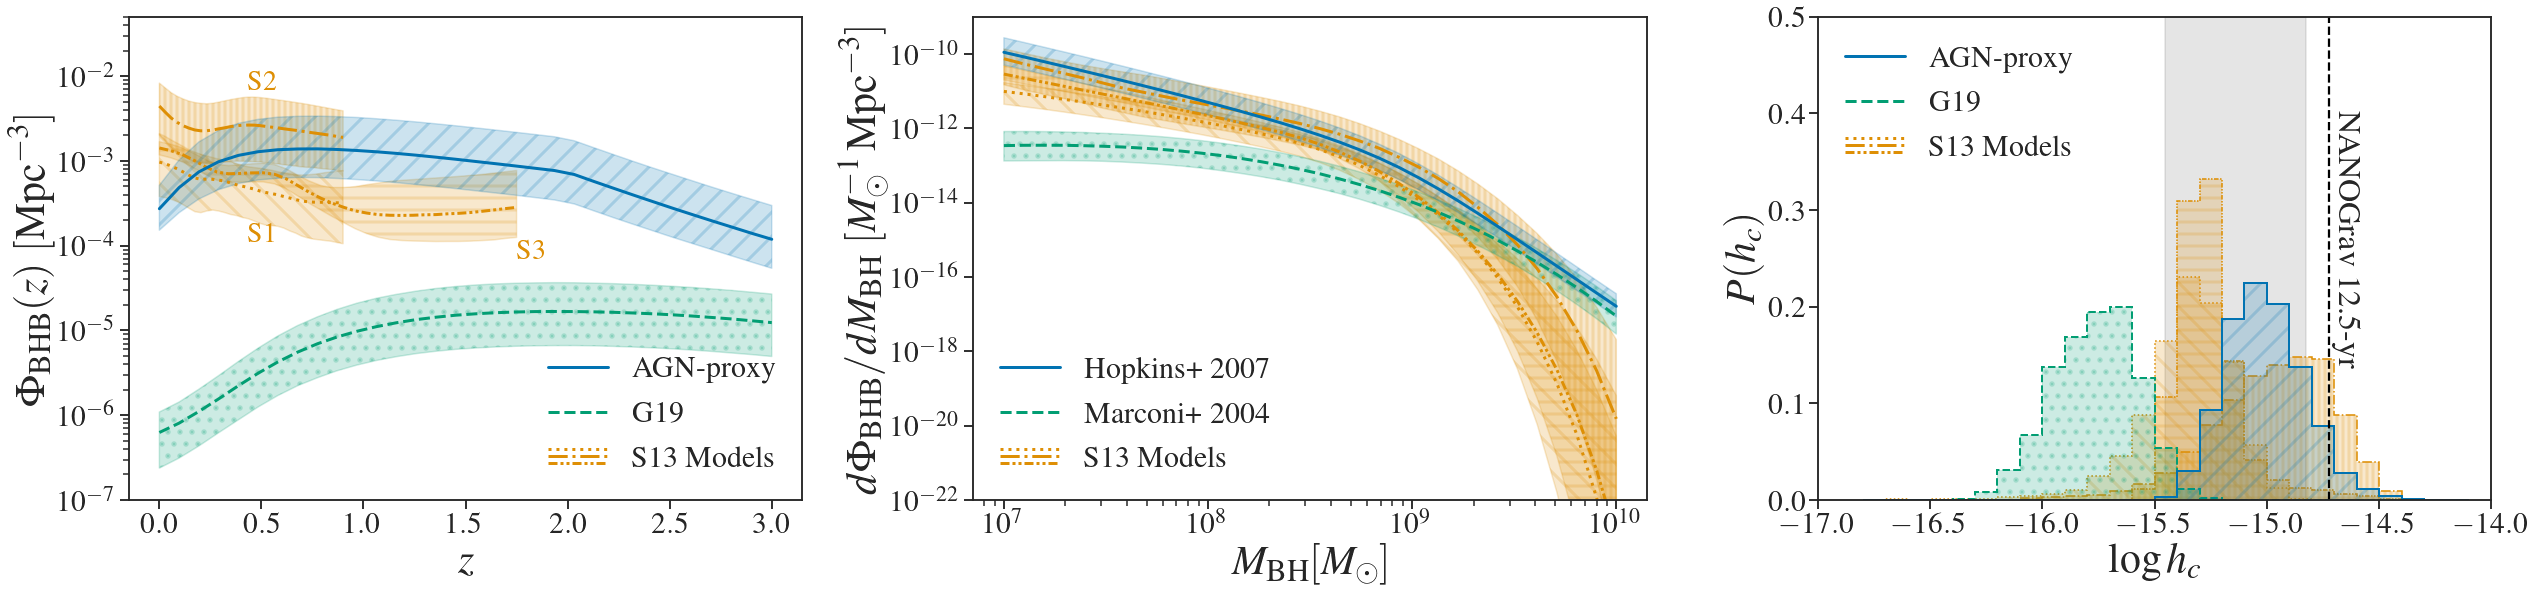

In [139]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                            S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                           S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(1, 3, figsize=(36, 9))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0].tick_params()
ax[1].tick_params()

ax[0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0].text(z_range_borch[int(n_mesh / 2) - 1], .9 * S1_number_density_q[0, int(n_mesh / 2) - 1], 'S1', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0].text(z_range_drory[int(n_mesh / 2) - 1], 1.05 * S2_number_density_q[2, int(n_mesh / 2) - 1], 'S2', color=cs[1],
           verticalalignment='bottom', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0].text(z_range_ilbert[n_mesh - 1], .95 * S3_number_density_q[0, n_mesh - 1], 'S3', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range, G19_number_density_q[0], G19_number_density_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[0].plot(z_range, G19_number_density_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Phi_{\rm{BHB}}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0].set_ylim(top=5e-2, bottom=1e-7)

ax[0].legend([m1, m2, (s1, s2, s3)], ['AGN-proxy', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', frameon=False, fontsize=legend_fsize)

ax[1].fill_between(10 ** log_m_bh_range, S1_local_bhmf_q[0], S1_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[1].plot(10 ** log_m_bh_range, S1_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[1].fill_between(10 ** log_m_bh_range, S2_local_bhmf_q[0], S2_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[1].plot(10 ** log_m_bh_range, S2_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[1].fill_between(10 ** log_m_bh_range, S3_local_bhmf_q[0], S3_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[1].plot(10 ** log_m_bh_range, S3_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

ax[1].fill_between(10 ** log_m_bh_range, G19_local_bhmf_q[0], G19_local_bhmf_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[1].plot(10 ** log_m_bh_range, G19_local_bhmf_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[1].fill_between(10 ** log_m_bh_range, local_bhmf_q[0], local_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[1].plot(10 ** log_m_bh_range, local_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1].set_ylim(bottom=1e-22, top=1e-9)
ax[1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', frameon=False, fontsize=legend_fsize)

ax[2].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2, fill=True, alpha=.2, hatch='.')
ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2)

ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-proxy', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-proxy', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

# ax[2].annotate(r'S13',
#                xy=(log_sesana_min - .3, .49))
# ax[2].errorbar(log_hc_mid, 0.45,
#              xerr=[[log_hc_l],
#                    [log_hc_h]],
#              capsize=4, color=cs[0])
# ax[2].annotate(r'This Work',
#                xy=(log_hc_min - .75, .44))

ax[2].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[2].annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .4), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
ax[2].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[2].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[2].set_xlim(left=-17, right=-14)
ax[2].set_ylim(top=.5)
ax[2].legend([m1, m2, (s1, s2, s3)], ['AGN-proxy', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.pdf')
plt.savefig('../reports/figures/model_comparison.png')
plt.show()